<a href="https://colab.research.google.com/github/harshitbhavnani/Deep-Learning/blob/main/Deep_Learning_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def stockpricepredictor(company):
  
  #Importing Libraries
  
  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  import pandas_datareader as web
  import datetime as dt

  from sklearn.preprocessing import MinMaxScaler
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout, LSTM

  from tqdm.keras import TqdmCallback

  import logging
  logging.getLogger('tensorflow').disabled = True

  prediction_days = int(input("Enter the numbers of days that need to be taken into consideration for making predictions: "))

  days_pred = int(input("Enter the number of days that you wish to derive projections for: "))

  start = (dt.datetime.today() - dt.timedelta(days = 2000))
  end = (dt.datetime.today() - dt.timedelta(days = 60))
  print(f"\nStock data is taken from: ",start)
  print(f"\nStock data is taken until: ",end,"\n")

  data = web.DataReader(company,'yahoo',start,end)

  #Prepare Data
  scalar = MinMaxScaler(feature_range=(0,1))
  scaled_data = scalar.fit_transform(data['Close'].values.reshape(-1,1))

  x_train=[]
  y_train=[]

  for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

  #Build the model
  model = Sequential()

  model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1],1)))
  model.add(LSTM(50,return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))

  model.compile(optimizer='adam',loss='mean_squared_error')

  model.fit(x_train,y_train,epochs=100,batch_size=64,verbose=0,callbacks=[TqdmCallback()])

  "'Test the Model Accuracy on Existing Data'"

  #Load Test Data
  test_start = (dt.datetime.now() - dt.timedelta(days = 61))
  test_end = dt.datetime.now()

  test_data = web.DataReader(company,'yahoo',test_start,test_end)

  actual_prices = test_data['Close'].values

  total_dataset = pd.concat((data['Close'], test_data['Close']))

  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
  model_inputs = model_inputs.reshape(-1,1)
  model_inputs = scalar.transform(model_inputs)

  #Make Predictions on Test Data
  x_test = []

  for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
  
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

  real_data = [model_inputs[len(model_inputs) - prediction_days: len(model_inputs+1), 0 ]]
  real_data = np.array(real_data)
  real_data = np.reshape(real_data,(real_data.shape[0], real_data.shape[1],1))

  predicted_prices = model.predict(x_test)
  predicted_prices = scalar.inverse_transform(predicted_prices)

  print(f"Projected stock price for tomorrow: {scalar.inverse_transform(model.predict(real_data))}")

  for i in range(days_pred):

    prediction = model.predict(real_data)
    prediction = scalar.inverse_transform(prediction)
    predicted_prices = np.append(predicted_prices,prediction,axis=0)
    #print(f"Projected stock price after {i+1} Day(s): {prediction}")

    #y_pred=y_pred.append(scalar.inverse_transform(prediction.reshape(-1,1)))
    prediction = scalar.fit_transform(prediction).reshape(1,-1,1)
    real_data = np.append(real_data,prediction,axis=1)

  if (days_pred!=1):
    print(f"Projected stock price after {days_pred} Days: {scalar.inverse_transform(prediction.reshape(-1,1))}")

  #Plot the test predictions

  plt.plot(actual_prices, color = 'black', label = f"Actual {company} Price")
  plt.plot(predicted_prices, color = 'green', label = f"Predicted {company} Price")
  plt.title(f"{company} Share Price")
  plt.xlabel('Time')
  plt.ylabel(f'{company} Share Price')
  plt.legend()
  plt.show()  

  y_pred = predicted_prices[len(predicted_prices)-days_pred:len(predicted_prices)]
  return y_pred

Enter the numbers of days that need to be taken into consideration for making predictions: 60
Enter the number of days that you wish to derive projections for: 5

Stock data is taken from:  2015-10-08 19:05:39.477962

Stock data is taken until:  2021-01-29 19:05:39.477973 




Projected stock price for tomorrow: [[123.7972]]
Projected stock price after 5 Days: [[124.877235]]


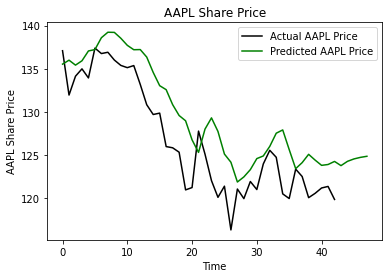

In [ ]:
predictions = stockpricepredictor('AAPL')

In [ ]:
if __name__ == '__main__':
    stockpricepredictor(company)